In [1]:
#!pip install nilearn
from nilearn import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#nilearn - neuroimaging tailored library
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

#keras - for NN models
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM
from keras import optimizers
from keras.utils import plot_model
from keras import utils
from sklearn.metrics import roc_curve


#scipy- statistical analysis tools
from scipy.stats import ttest_1samp
from scipy import interp

2023-02-02 12:34:08.228716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Preparing data for analysis

In [2]:
## load the smith (ICA based) mask
## 'rsn10': 10 ICA maps from the above that matched across task and rest
# http://brainmap.org/pubs/SmithPNAS09.pdf

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn70


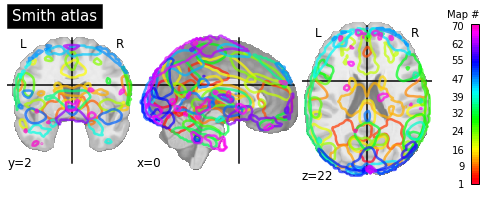

In [3]:
plotting.plot_prob_atlas(smith_atlas_rs_networks, 
                         title='Smith atlas',  
                         colorbar=True)
plotting.show()

In [4]:
# Import preprocessed, ready-to-go, datasets
adhd_data=datasets.fetch_adhd(n_subjects=40)

In [5]:
adhd_data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [6]:
# exploring the header of one image 
import nibabel as nib
img=nib.load(adhd_data['func'][0])

print(img.header['dim'])
print(img.header['pixdim'])


[  4  61  73  61 176   1   1   1]
[-1.  3.  3.  3.  2.  0.  0.  0.]


In [7]:
# Region signals extraction- exctract the values of the ten networks

masker = NiftiMapsMasker(maps_img=smith_atlas_rs_networks,  # Smith stals
                         standardize=True, # centers and norms the time-series
                         memory='nilearn_cache', # cache
                         verbose=0) #do not print verbose

In [8]:
all_subjects_data=[]
labels=[]  # 1 if ADHD, 0 if control

for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    
    all_subjects_data.append(time_series)
    labels.append(phenotypic['adhd'])


In [9]:
print('N control:' ,labels.count(0))
print('N adhd:' ,labels.count(1))

N control: 20
N adhd: 20


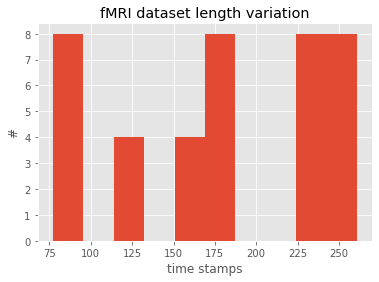

In [10]:
plt.hist([len(i) for i in all_subjects_data])
plt.title('fMRI dataset length variation')
plt.xlabel('time stamps')
plt.ylabel('#')
plt.show()

In [11]:
# find the longest image
max_len_image=np.max([len(i) for i in all_subjects_data])


In [12]:
max_len_image

261

In [13]:
# reshape 

all_subjects_data_reshaped=[]
for subject_data in all_subjects_data:
  # Padding
  N= max_len_image-len(subject_data)
  padded_array=np.pad(subject_data, ((0, N), (0,0)), 
                      'constant', constant_values=(0))
  subject_data=padded_array
  subject_data=np.array(subject_data)
  subject_data.reshape(subject_data.shape[0],subject_data.shape[1],1)
  all_subjects_data_reshaped.append(subject_data)


In [14]:
# shape of data

# 40 subjects
# 261 time stamps
# 10 netwroks values

np.array(all_subjects_data_reshaped).shape

(40, 261, 70)

In [15]:
# The data, split between train and test sets.

def get_train_test(X, y, i, verbrose=False):
  '''
  split to train and test and reshape data
  X data
  y labels
  i random state
  '''
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)



  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=np.array(all_subjects_data_reshaped).shape[1]
  RSN_shape=np.array(all_subjects_data_reshaped).shape[2]
  
  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 2)
  y_test = utils.to_categorical(y_test, 2)
  
  return X_train, X_test, y_train, y_test



Build the LSTM model

In [16]:
# create the model

model = Sequential()

# LSTM layers - 
# Long Short-Term Memory layer - Hochreiter 1997.
t_shape=np.array(all_subjects_data_reshaped).shape[1]
RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

model.add(LSTM(units=70, # dimensionality of the output space 
               dropout=0.4, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, # Fraction of the units to drop (recurent state)
               return_sequences=True, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(LSTM(units=60,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=50,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=40,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=False))


model.add(Dense(units=2, 
                activation="sigmoid"))

model.compile(loss='binary_crossentropy', 
                optimizer=optimizers.Adam(lr=0.001), 
                metrics=['binary_accuracy'])

print(model.summary())



2023-02-02 12:36:32.819145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 261, 70)           39480     
                                                                 
 lstm_1 (LSTM)               (None, 261, 60)           31440     
                                                                 
 lstm_2 (LSTM)               (None, 261, 50)           22200     
                                                                 
 lstm_3 (LSTM)               (None, 40)                14560     
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 107,762
Trainable params: 107,762
Non-trainable params: 0
_________________________________________________________________
None


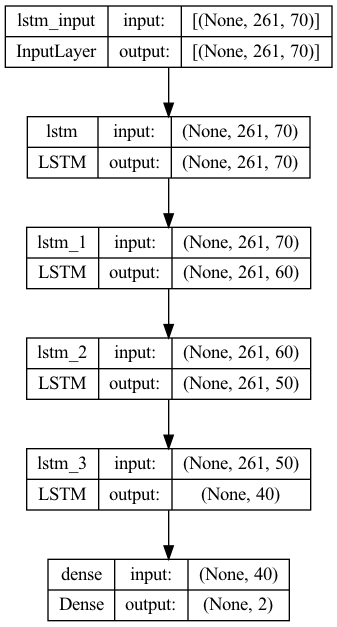

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

Train the LSTM model

32 train samples
8 test samples
Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 0.6929 - binary_accuracy: 0.5600 - val_loss: 0.6957 - val_binary_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 1s 992ms/step - loss: 0.6909 - binary_accuracy: 0.6600 - val_loss: 0.6969 - val_binary_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.6860 - binary_accuracy: 0.6000 - val_loss: 0.6974 - val_binary_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 1s 929ms/step - loss: 0.6838 - binary_accuracy: 0.6200 - val_loss: 0.6980 - val_binary_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 1s 977ms/step - loss: 0.6773 - binary_accuracy: 0.6600 - val_loss: 0.6981 - val_binary_accuracy: 0.5714
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.6789 - binary_accuracy: 0.6000 - val_loss: 0.6984 - val_binary_accuracy: 0.5714
Epoch 7/30
1/1 [==============================] - 1s 

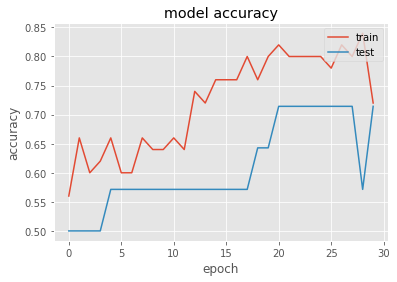

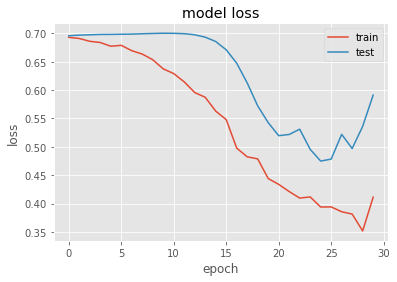

In [18]:
X_train, X_test, y_train, y_test = get_train_test(all_subjects_data_reshaped,
                                                    labels, i=8, verbrose=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30)

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


Evaluate the LSTM model

In [19]:
from sklearn.metrics import accuracy_score

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=100, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_subjects_data_reshaped,
                                              labels, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr 



accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr  = boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test)

fitting..
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.4914 - binary_accuracy: 0.7200 - val_loss: 0.4994 - val_binary_accuracy: 0.8571
Epoch 2/50
1/1 [==============================] - 1s 869ms/step - loss: 0.5096 - binary_accuracy: 0.8400 - val_loss: 0.7305 - val_binary_accuracy: 0.4286
Epoch 3/50
1/1 [==============================] - 1s 870ms/step - loss: 0.3929 - binary_accuracy: 0.8000 - val_loss: 0.8168 - val_binary_accuracy: 0.4286
Epoch 4/50
1/1 [==============================] - 1s 820ms/step - loss: 0.4268 - binary_accuracy: 0.7400 - val_loss: 0.8132 - val_binary_accuracy: 0.5714
Epoch 5/50
1/1 [==============================] - 1s 988ms/step - loss: 0.3420 - binary_accuracy: 0.8000 - val_loss: 0.8475 - val_binary_accuracy: 0.7143
Epoch 6/50
1/1 [==============================] - 1s 886ms/step - loss: 0.3535 - binary_accuracy: 0.8000 - val_loss: 0.9183 - val_binary_accuracy: 0.6429
Epoch 7/50
1/1 [==============================] - 1s 791ms/step - los

In [ ]:
def calc_p_val(stats, h0):
  '''
  finds the p value for the results 
  
  '''
  # calc pval
  tset, pval = ttest_1samp(stats, h0)

  return pval

p_val=calc_p_val(accuracy, .5)

In [ ]:
def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats, label='bootstrapped test')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')

  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()

plot_p_value(accuracy, p_val)

In [ ]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)